# Importing Libraries and Dataset

In [ ]:
!pip install pytorch_forecasting

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import itertools

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls /content/drive/MyDrive/Forecasting_Project/Data/LD2011_2014.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Forecasting_Project/Data/LD2011_2014.txt


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Forecasting_Project/Data/LD2011_2014.txt", delimiter=";", engine="python")

In [ ]:
df

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140251,2014-12-31 23:00:00,"2,53807106598985","22,0483641536273","1,73761946133797","150,406504065041","85,3658536585366","303,571428571429","11,3058224985868","282,828282828283","68,1818181818182",...,"276,945039257673",28200.0,"1616,03375527426","1363,63636363636","29,986962190352","5,85137507314219","697,102721685689","176,961602671119","651,026392961877","7621,62162162162"
140252,2014-12-31 23:15:00,"2,53807106598985","21,3371266002845","1,73761946133797","166,666666666667","81,7073170731707","324,404761904762","11,3058224985868","252,525252525253","64,6853146853147",...,"279,800142755175",28300.0,"1569,62025316456","1340,90909090909","29,986962190352","9,94733762434172","671,641791044776","168,614357262104","669,354838709677","6702,7027027027"
140253,2014-12-31 23:30:00,"2,53807106598985","20,6258890469417","1,73761946133797","162,60162601626","82,9268292682927","318,452380952381","10,1752402487281","242,424242424242","61,1888111888112",...,"284,796573875803",27800.0,"1556,96202531646","1318,18181818182","27,3794002607562","9,3622001170275","670,763827919227","153,589315525876","670,087976539589","6864,86486486487"
140254,2014-12-31 23:45:00,"1,26903553299492","21,3371266002845","1,73761946133797","166,666666666667","85,3658536585366","285,714285714286","10,1752402487281","225,589225589226","64,6853146853147",...,"246,252676659529",28000.0,"1443,03797468354","909,090909090909","26,0756192959583","4,09596255119953","664,618086040386","146,911519198664","646,627565982405","6540,54054054054"


# Data Preprocessing

In [ ]:
df.loc[:, df.columns != 'Unnamed: 0'] = df.loc[:, df.columns != 'Unnamed: 0'].applymap(
    lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x
)

In [ ]:
print('Number of Records : ' + str(len(df)))
duplicates = df[df.duplicated(keep=False)]
if not duplicates.empty:
    print("Duplicate rows found:\n", duplicates)

    plt.figure(figsize=(10, 6))

    if df.select_dtypes(include=["number"]).shape[1] > 1:
        sns.pairplot(duplicates)
    else:
        sns.countplot(y=duplicates.iloc[:, 0], data=duplicates)

    plt.title("Visualization of Duplicate Rows")
    plt.show()
else:
    print("No duplicate rows found!")

Number of Records : 140256
No duplicate rows found!


In [ ]:
str(df.isna().any(axis=None))

'False'

In [ ]:
df.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])
df = df.iloc[:-1]

In [ ]:

# df.to_csv("/content/drive/MyDrive/Forecasting_Project/Data/preprocessed.csv")


In [ ]:
df

,Time,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140250,2014-12-31 22:45:00,1.269036,22.048364,1.737619,156.504065,85.365854,315.47619,11.305822,245.791246,69.93007,...,295.503212,31600.0,1624.472574,1340.909091,31.290743,4.6811,707.638279,188.647746,652.492669,7189.189189
140251,2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
140252,2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
140253,2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.17524,242.424242,61.188811,...,284.796574,27800.0,1556.962025,1318.181818,27.3794,9.3622,670.763828,153.589316,670.087977,6864.864865


In [ ]:
# zero_counts = (df == 0).sum().tolist()

# number_50_percent = 0
# for i in range(len(df.columns)):
#   if zero_counts[i]>=70128:
#     if i//10<1:
#       df = df.drop(columns=['MT_00'+str(i)])
#     elif i//100<1:
#       df = df.drop(columns=['MT_0'+str(i)])
#     else:
#       df = df.drop(columns=['MT_'+str(i)])

# Data Analysis

## Monthly Analysis

In [ ]:
df_monthly_avg = df.set_index('Time').replace(0.0, np.nan)
df_monthly_avg = df_monthly_avg.resample('M').mean()

df_monthly_avg = pd.DataFrame({"Date": df_monthly_avg.index,
                               "Avg_Electricity_Consumption": df_monthly_avg.mean(axis=1)}).reset_index(drop=True)

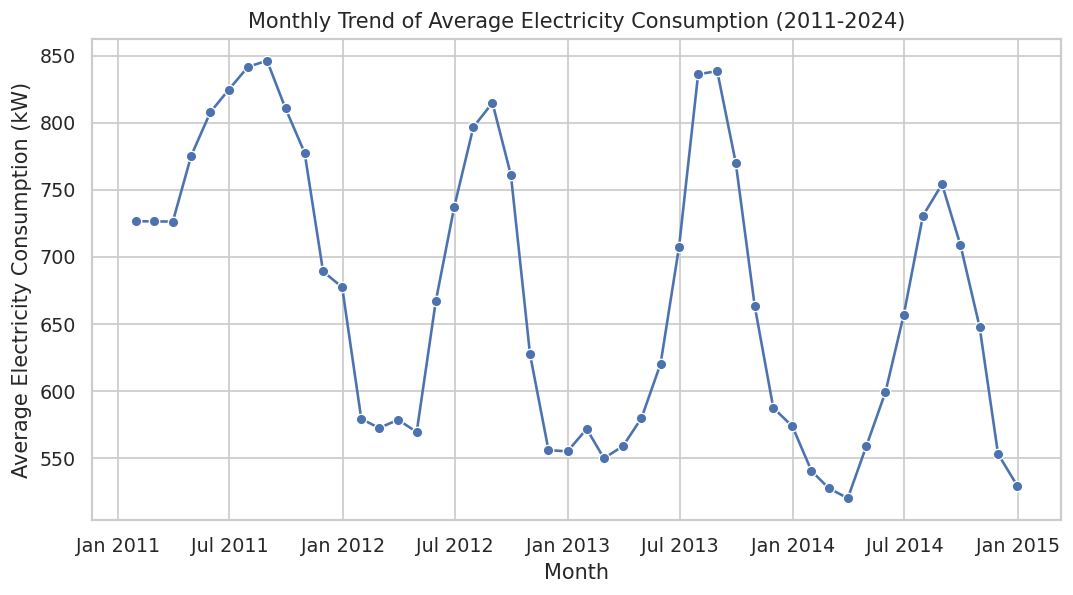

In [ ]:
sns.set_theme(style = "whitegrid")

plt.figure(figsize=(10,5), dpi=125)
sns.lineplot(data = df_monthly_avg, x = "Date", y = "Avg_Electricity_Consumption", marker = "o")
plt.xlabel("Month")
plt.ylabel("Average Electricity Consumption (kW)")
plt.title("Monthly Trend of Average Electricity Consumption (2011-2024)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show()

## Daily Trend Analysis

In [ ]:
df_daily_avg = df.set_index('Time').replace(0.0, np.nan)

df_daily_avg = df_daily_avg.resample('D').mean()

df_daily_avg = pd.DataFrame({
    "Date": df_daily_avg.index,
    "Avg_Electricity_Consumption": df_daily_avg.mean(axis=1)
}).reset_index(drop=True)

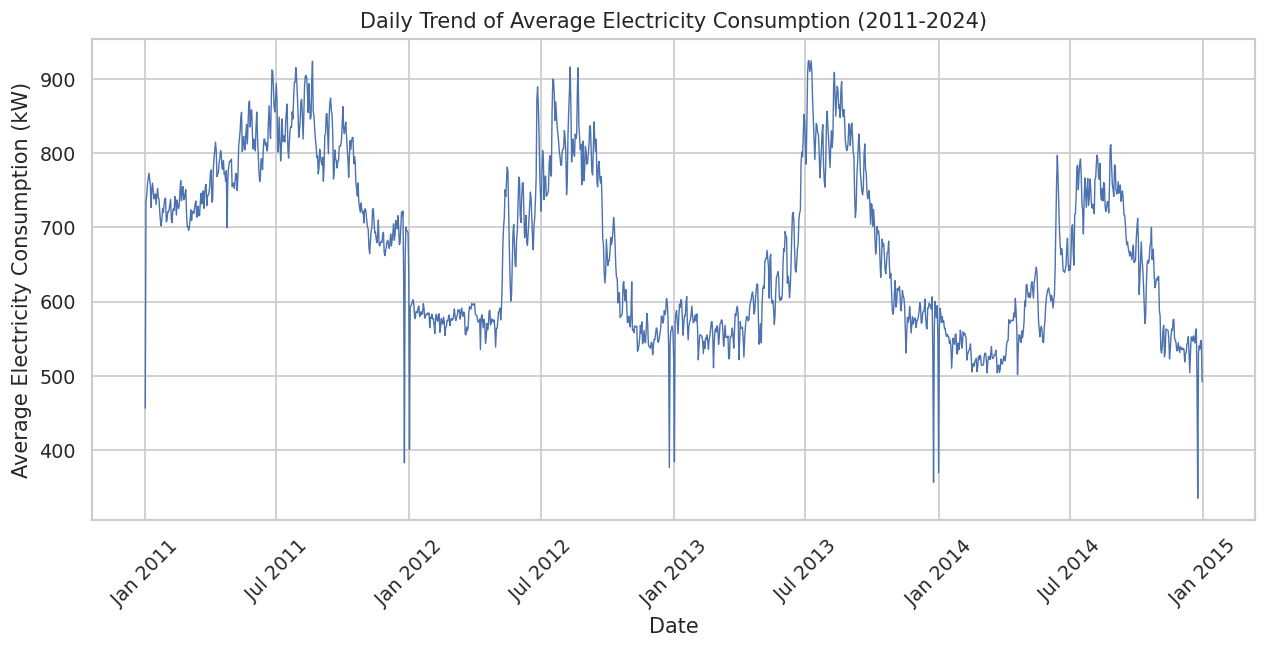

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 5), dpi=125)
sns.lineplot(data=df_daily_avg, x="Date", y="Avg_Electricity_Consumption", linewidth=0.8)

plt.xlabel("Date")
plt.ylabel("Average Electricity Consumption (kW)")
plt.title("Daily Trend of Average Electricity Consumption (2011-2024)")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.show()

## Yearly Trend Analysis

In [ ]:
df_yearly_avg = df.set_index('Time').replace(0.0, np.nan)
df_yearly_avg = df_yearly_avg.resample('Y').mean()

df_yearly_avg = pd.DataFrame({"Date": df_yearly_avg.index,
                               "Avg_Electricity_Consumption_Year": df_yearly_avg.mean(axis=1)}).reset_index(drop=True)

Text(0.5, 1.0, 'Yearly Average Electricity Consumption (2011-2024)')

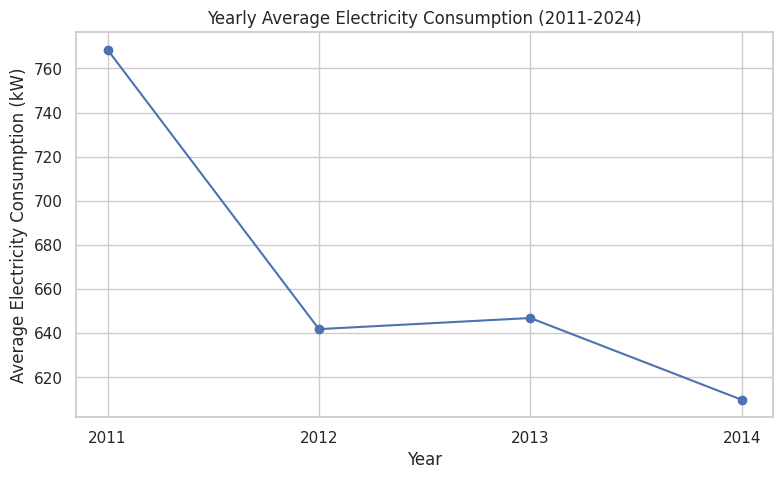

In [ ]:
plt.figure(figsize=(9,5))
years = df_yearly_avg['Date'].dt.year

plt.plot(years, df_yearly_avg['Avg_Electricity_Consumption_Year'], marker = "o")
plt.xticks(years)
plt.xlabel("Year")
plt.ylabel("Average Electricity Consumption (kW)")
plt.title("Yearly Average Electricity Consumption (2011-2024)")

## SEASONAL TREND ANALYSIS

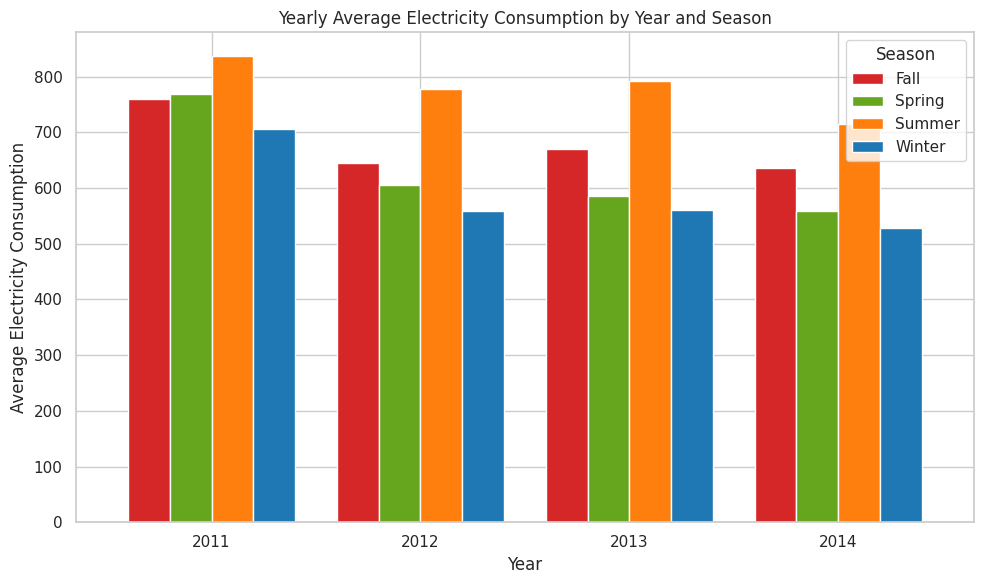

In [ ]:
df_seasonal_avg = df.set_index('Time').replace(0.0, np.nan).copy()

# Remove existing 'Year' and 'Season' columns if they already exist
df_seasonal_avg = df_seasonal_avg.drop(columns=['Year', 'Season'], errors='ignore')

# Define seasons
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
}

season_colors = {
    'Summer': '#ff7f0e',
    'Fall': '#d62728',
    'Winter': '#1f77b4',
    'Spring': '#66a61e'
}

# Extract season and year
df_seasonal_avg['Year'] = df_seasonal_avg.index.year
df_seasonal_avg['Year'] = df_seasonal_avg['Year'].astype(int)
df_seasonal_avg['Season'] = df_seasonal_avg.index.month.map(season_map)

non_numeric_cols = ['Time']
numeric_cols = df.columns[1:]

df_seasonal_avg = df_seasonal_avg.groupby(['Year', 'Season'], as_index=False)[numeric_cols].mean()

df_seasonal_avg['MT_average'] =  df_seasonal_avg[numeric_cols].mean(axis=1)

grouped = df_seasonal_avg.groupby(['Year', 'Season'])['MT_average'].mean().unstack()

# grouped.plot(kind='bar', figsize=(10, 6), width=0.8)
# plt.title('Average Values by Year and Season')
# plt.xlabel('Year')
# plt.ylabel('Average Value')
# plt.xticks(rotation=0)
# plt.legend(title='Season')
# plt.tight_layout()
# plt.show()

ax = grouped.plot(kind='bar', figsize=(10, 6), width=0.8, color=[season_colors[season] for season in grouped.columns])

plt.title('Yearly Average Electricity Consumption by Year and Season')
plt.xlabel('Year')
plt.ylabel('Average Electricity Consumption')
plt.xticks(rotation=0)
plt.legend(title='Season')
plt.tight_layout()
plt.show()

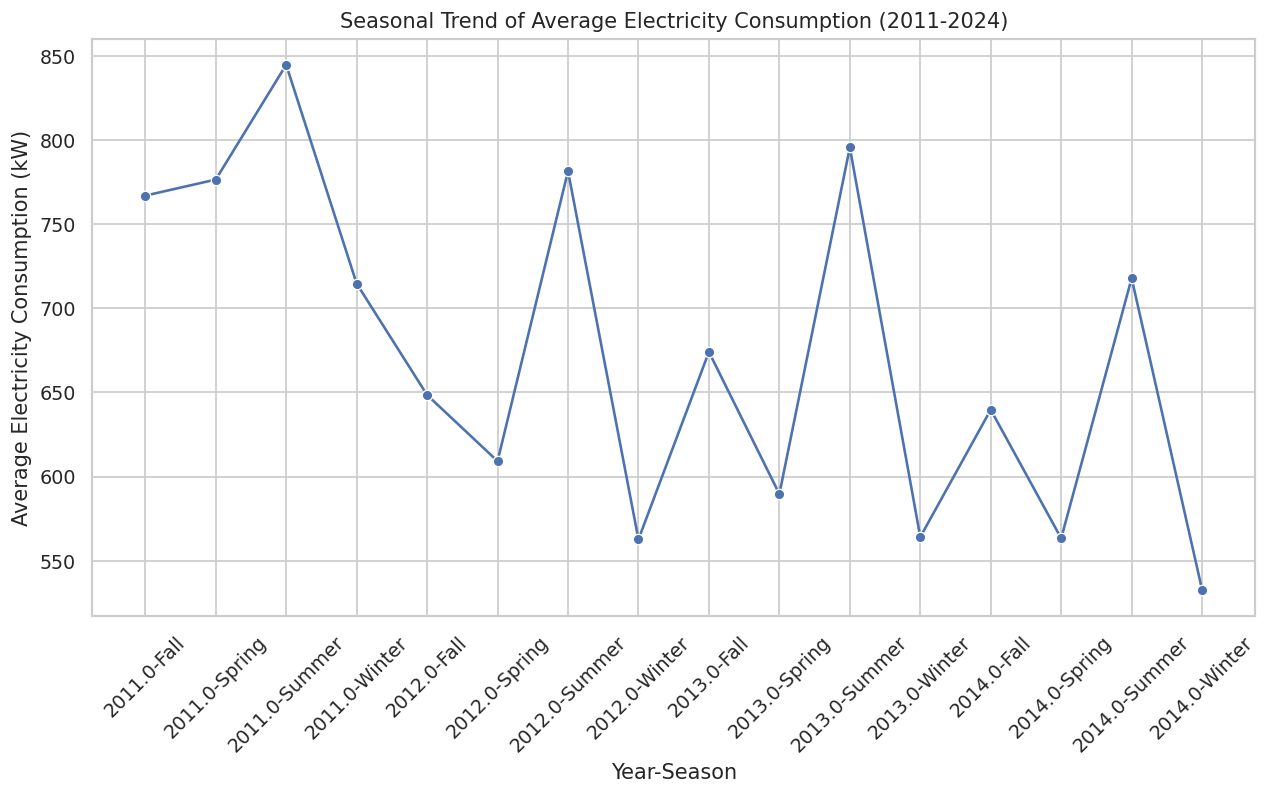

In [ ]:
df_seasonal_avg = df.set_index('Time').replace(0.0, np.nan).copy()

# Remove existing 'Year' and 'Season' columns if they already exist
df_seasonal_avg = df_seasonal_avg.drop(columns=['Year', 'Season'], errors='ignore')

# Define seasons
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
    3: "Spring", 4: "Spring", 5: "Spring",
    6: "Summer", 7: "Summer", 8: "Summer",
    9: "Fall", 10: "Fall", 11: "Fall"
}

# Extract season and year
df_seasonal_avg['Year'] = df_seasonal_avg.index.year
df_seasonal_avg['Year'] = df_seasonal_avg['Year'].astype(int)
df_seasonal_avg['Season'] = df_seasonal_avg.index.month.map(season_map)

# Select only numeric columns for averaging
numeric_cols = df_seasonal_avg.select_dtypes(include=[np.number]).columns

# Group by Year + Season and compute mean for numeric columns
df_seasonal_avg = df_seasonal_avg.groupby(['Year', 'Season'], as_index=False)[numeric_cols].mean()

# Create "Year + Season" column for plotting
df_seasonal_avg['Year_Season'] = df_seasonal_avg['Year'].astype(str) + "-" + df_seasonal_avg['Season']

# Plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6), dpi=125)
sns.lineplot(data=df_seasonal_avg, x="Year_Season", y=df_seasonal_avg[numeric_cols].mean(axis=1), marker="o")

plt.xlabel("Year-Season")
plt.ylabel("Average Electricity Consumption (kW)")
plt.title("Seasonal Trend of Average Electricity Consumption (2011-2024)")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

# Stationarity Check

1. Check using ADF Test

In [ ]:
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The data is stationary (reject null hypothesis).")
    else:
        print("The data is non-stationary (fail to reject null hypothesis).")

print("Augmented Dickey-Fuller Test for Monthly Average Electricity Consumption:")
adf_test(df_monthly_avg["Avg_Electricity_Consumption"])


#adf_test(df_daily_avg["Avg_Electricity_Consumption"])
#adf_test(df_yearly_avg["Avg_Electricity_Consumption_Year"])


Augmented Dickey-Fuller Test for Monthly Average Electricity Consumption:
ADF Statistic: -2.672852733290107
p-value: 0.07885488696905468
Critical Values: {'1%': np.float64(-3.6155091011809297), '5%': np.float64(-2.941262357486514), '10%': np.float64(-2.6091995013850418)}
The data is non-stationary (fail to reject null hypothesis).


2. Visual Check

In [ ]:
def plot_rolling_statistics(series, title):
    rolling_mean = series.rolling(window=12).mean()
    rolling_std = series.rolling(window=12).std()

    plt.figure(figsize=(10, 5))
    plt.plot(series, label="Original Data", color="blue", alpha=0.5)
    plt.plot(rolling_mean, label="Rolling Mean (12 periods)", color="red", linestyle="dashed")

    # Fill between mean ± standard deviation
    plt.fill_between(series.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color="green", alpha=0.2, label="Rolling Std Dev")

    plt.xlabel("Time")
    plt.ylabel("Electricity Consumption (kW)")
    plt.title(f"Rolling Mean & Standard Deviation ({title})")
    plt.legend()
    plt.show()


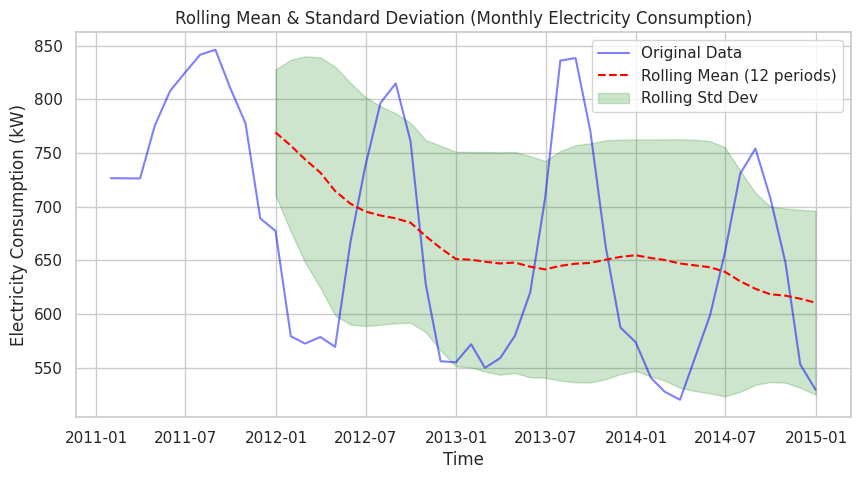

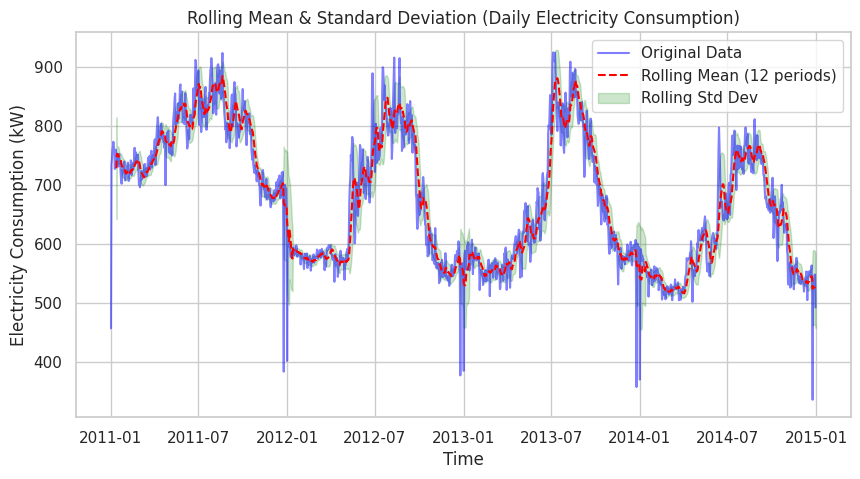

In [ ]:
plot_rolling_statistics(df_monthly_avg.set_index("Date")["Avg_Electricity_Consumption"], "Monthly Electricity Consumption")
plot_rolling_statistics(df_daily_avg.set_index("Date")["Avg_Electricity_Consumption"], "Daily Electricity Consumption")
#plot_rolling_statistics(df_yearly_avg.set_index("Date")["Avg_Electricity_Consumption_Year"], "Yearly Electricity Consumption")

# Preliminary Modeling with SARIMA (Month-wise aggregation)

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [ ]:
df_monthly_avg.set_index('Date', inplace=True)

p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12 # 12 since we are working with monthly averages

model = SARIMAX(df_monthly_avg, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

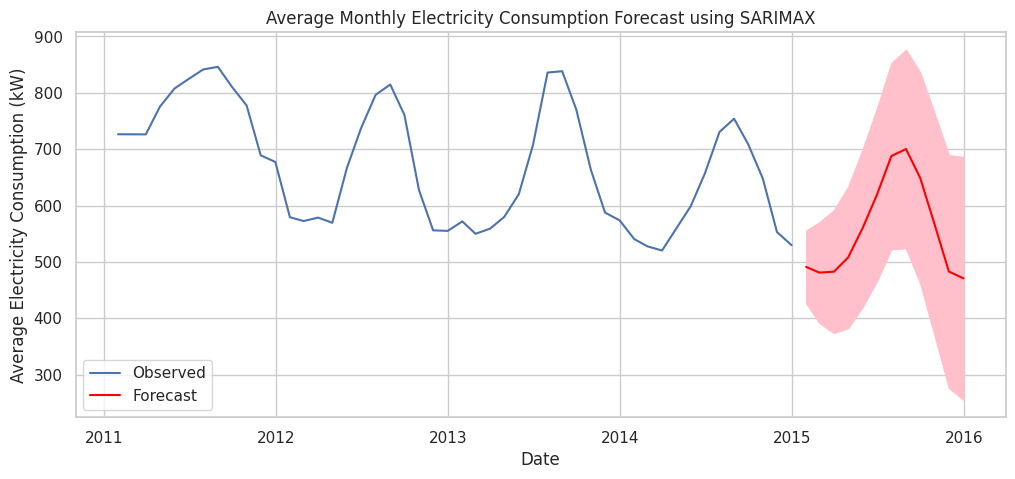

In [ ]:
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(df_monthly_avg, label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Average Monthly Electricity Consumption Forecast using SARIMAX")
plt.xlabel("Date")
plt.ylabel("Average Electricity Consumption (kW)")
plt.legend()
plt.show()

In [ ]:
observed = df_monthly_avg[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
print(f'MAE: {mae:.2f}')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = np.where(y_true == 0, np.nan, y_true)
    mape = np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

mape = mean_absolute_percentage_error(observed, forecast_mean)
print(f"MAPE: {mape:.2f}%")

MAE: 52.41
MAPE: 16.54%


# Preliminary Modeling with SARIMA (Day-wise aggregation)

In [ ]:
df_daily_avg.set_index('Date', inplace=True)

p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 365  # Yearly seasonality (365 days)

# Fit the SARIMAX model
model = SARIMAX(df_daily_avg, order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

KeyboardInterrupt: 

In [ ]:
forecast_periods = 365
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 5))
plt.plot(df_daily_avg, label='Observed', linewidth=1)
plt.plot(forecast_mean, label='Forecast', color='red', linewidth=1)
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)



# DATASET SPLITTING

In [ ]:
monthly_avg = df_monthly_avg['Avg_Electricity_Consumption'].tolist()

In [ ]:
def split_sequence(sequence, X_steps, y_steps):
	X, y = [], []
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + X_steps + y_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:i+X_steps], sequence[i+X_steps:i+X_steps+y_steps]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

In [ ]:
X_steps = 10            # Temporary Value
y_steps = 2             # Temporary Value
X, y = split_sequence(monthly_avg, X_steps, y_steps)
for i in range(2):
	print(X[i], y[i])

[726.5056942117512, 726.3956147777762, 726.2464689768383, 775.4772294721622, 807.7541322672712, 824.6397997296987, 841.5353511246897, 846.1346648292449, 810.5638597765906, 777.6021541760294] [689.0826748299296, 677.3236285000255]
[726.3956147777762, 726.2464689768383, 775.4772294721622, 807.7541322672712, 824.6397997296987, 841.5353511246897, 846.1346648292449, 810.5638597765906, 777.6021541760294, 689.0826748299296] [677.3236285000255, 579.2486697068448]


In [ ]:
# First, split into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Then, split temp into validation (50% of temp) and test (50% of temp)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

## Holt's Winter Smoothening

In [ ]:
train_holts = monthly_avg[:39]
test_holts = monthly_avg[39:]

hw_model = ExponentialSmoothing(
    train_holts,
    trend="multiplicative",
    seasonal="mul",
    seasonal_periods=12
).fit()

forecast_periods = 9
forecast = hw_model.forecast(forecast_periods)

In [ ]:
mape = mean_absolute_percentage_error(test_holts, forecast)
print(f"MAPE: {mape:.2f}%")

MAPE: 6.74%


In [ ]:
hw_model = ExponentialSmoothing(
    train_holts,
    trend="additive",
    seasonal="add",
    seasonal_periods=12
).fit()

forecast_periods = 9
forecast = hw_model.forecast(forecast_periods)

In [ ]:
mape = mean_absolute_percentage_error(test_holts, forecast)
print(f"MAPE: {mape:.2f}%")

MAPE: 3.80%


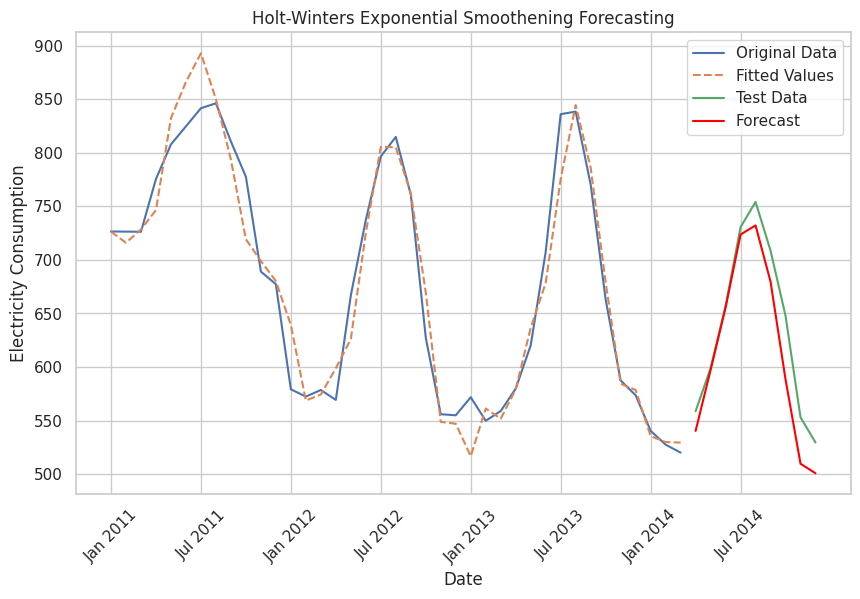

In [ ]:
from datetime import datetime

forecast_range = np.arange(len(train_holts), len(train_holts) + len(forecast))
dates = pd.date_range(start='2011-01-01', periods=6, freq='MS')

plt.figure(figsize=(10, 6))
plt.plot(train_holts, label="Original Data")
plt.plot(hw_model.fittedvalues, label="Fitted Values", linestyle="--")
plt.plot(np.arange(len(train_holts), len(train_holts) + len(test_holts)), test_holts, label="Test Data")
plt.plot(forecast_range, forecast, label="Forecast", color="red")
tick_positions = range(0, 48, 6)
start_date = datetime(2011, 1, 1)
end_date = datetime(2014, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='6MS')
labels = date_range.strftime('%b %Y')
tick_labels = labels.tolist()
plt.xticks(tick_positions, tick_labels, rotation=45)
plt.xlabel("Date")
plt.ylabel("Electricity Consumption")
plt.title("Holt-Winters Exponential Smoothening Forecasting")
plt.legend()
plt.show()

# SARIMAX

In [ ]:
series = pd.Series(monthly_avg)

In [ ]:
train_size = 39  # same split as holt winters
train_sarima = series[:train_size]
test_sarima = series[train_size:]

In [ ]:
p, d, q = 1, 1, 1  # ARIMA order
P, D, Q, m = 1, 1, 1, 12  # Seasonal order with 12-month seasonality

In [ ]:
sarima_model = SARIMAX(
    train_sarima,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

In [ ]:
forecast_periods = len(test_sarima)
sarima_forecast = sarima_model.forecast(forecast_periods)

Baseline Model

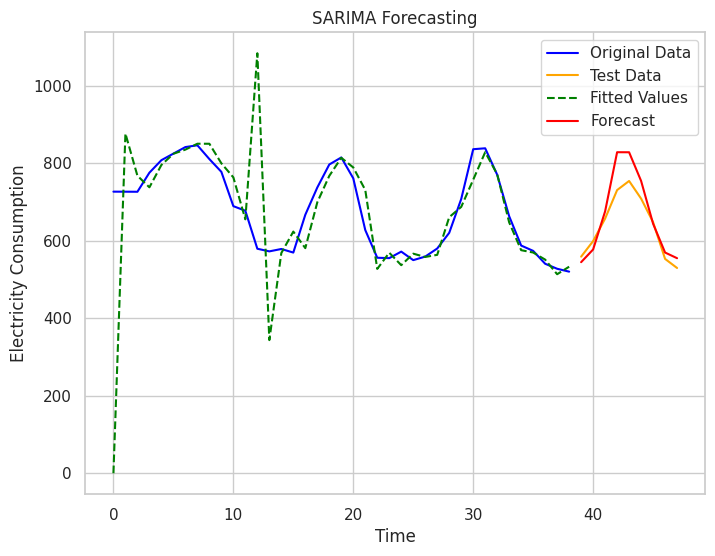

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_sarima, label="Original Data", color="blue")
plt.plot(np.arange(len(train_sarima), len(train_sarima) + len(test_sarima)),
         test_sarima, label="Test Data", color="orange")
plt.plot(sarima_model.fittedvalues, label="Fitted Values", linestyle="--", color="green")
plt.plot(np.arange(len(train_sarima), len(train_sarima) + len(sarima_forecast)),
         sarima_forecast, label="Forecast", color="red")

plt.title("SARIMA Forecasting")
plt.xlabel("Time")
plt.ylabel("Electricity Consumption")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
mape_score = mean_absolute_percentage_error(test_sarima, sarima_forecast)
print(f"MAPE Score: {mape_score:.2f}%")

MAPE Score: 5.22%


In [ ]:


# possible parameter ranges
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
P_values = [0, 1, 2]
D_values = [0, 1]
Q_values = [0, 1, 2]
m = 12  # (monthly data)

best_mape = float("inf")
best_params = None

for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(
            train_sarima,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False,
        ).fit()

        forecast = model.forecast(len(test_sarima))
        mape = mean_absolute_percentage_error(test_sarima, forecast)

        if mape < best_mape:
            best_mape = mape
            best_params = (p, d, q, P, D, Q)

    except:
        continue  # skip invalid models

print(f"Best MAPE Score: {best_mape:.2f}% with parameters {best_params}")

Best MAPE Score: 1.65% with parameters (2, 0, 1, 1, 0, 1)


Optimized SARIMA

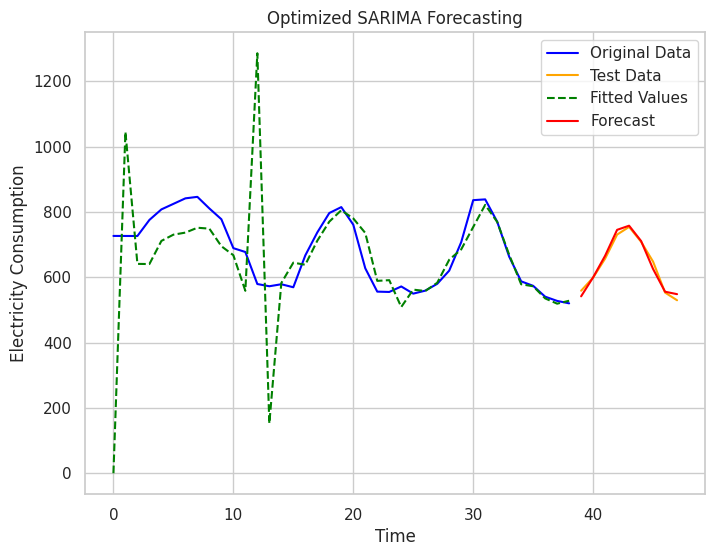

In [ ]:
p, d, q, P, D, Q = best_params

# Re-training
sarima_model = SARIMAX(
    train_sarima,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

sarima_forecast = sarima_model.forecast(len(test_sarima))

plt.figure(figsize=(8, 6))
plt.plot(train_sarima, label="Original Data", color="blue")
plt.plot(np.arange(len(train_sarima), len(train_sarima) + len(test_sarima)),
         test_sarima, label="Test Data", color="orange")
plt.plot(sarima_model.fittedvalues, label="Fitted Values", linestyle="--", color="green")
plt.plot(np.arange(len(train_sarima), len(train_sarima) + len(sarima_forecast)),
         sarima_forecast, label="Forecast", color="red")

plt.title("Optimized SARIMA Forecasting")
plt.xlabel("Time")
plt.ylabel("Electricity Consumption")
plt.legend()
plt.grid(True)
plt.show()

Predictive Results

In [ ]:
sarima_predict= SARIMAX(
    monthly_avg,
    order=(p, d, q),
    seasonal_order=(P, D, Q, m),
    enforce_stationarity=False,
    enforce_invertibility=False,
).fit()

predicted_values = sarima_model.forecast(12)

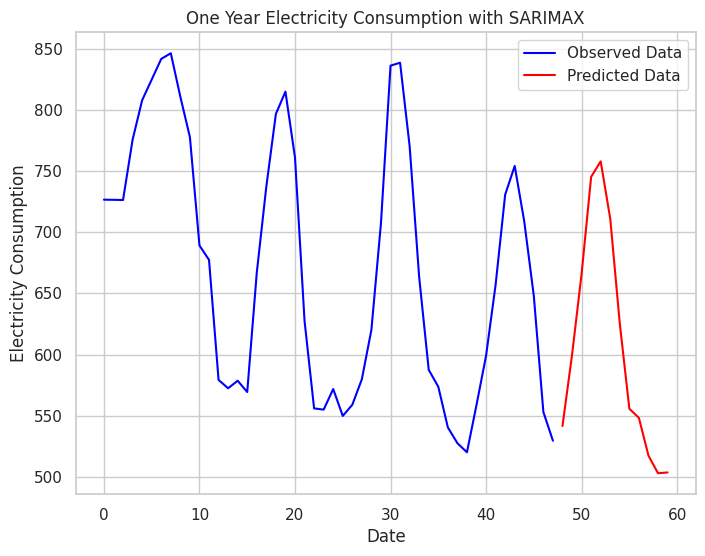

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(monthly_avg, color="blue", label="Observed Data")
plt.plot(np.arange(len(monthly_avg), len(monthly_avg) + len(predicted_values)),
         predicted_values, label="Predicted Data", color="red")

plt.title("One Year Electricity Consumption with SARIMAX")
plt.xlabel("Date")
plt.ylabel("Electricity Consumption")
plt.legend()
plt.grid(True)
plt.show()

## Facebook Prophet

In [ ]:
df_prophet = df_monthly_avg.rename(columns={'Avg_Electricity_Consumption': 'y'}).reset_index()
df_prophet.rename(columns={'Date': 'ds'}, inplace=True)

In [ ]:
split_idx = len(X_train) + X_steps - 1
df_train = df_prophet.iloc[:split_idx + 1]
df_test = df_prophet.iloc[split_idx + 1:]

In [ ]:
fourier_orders = [4, 5, 6, 7]
prior_scales = [0.1, 0.5, 1.0, 5.0]

results = []

train_data = df_train.copy()
test_data = df_test.copy()

for order in fourier_orders:
    for scale in prior_scales:
        model = Prophet(
            seasonality_mode='multiplicative',
            changepoint_range=0.9,
            yearly_seasonality=False,
            changepoint_prior_scale=0.05
        )

        model.add_seasonality(
            name='custom_yearly',
            period=365.25,
            fourier_order=order,
            prior_scale=scale
        )

        model.fit(train_data)
        periods_needed = ((test_data['ds'].max().to_period('M') - train_data['ds'].max().to_period('M')).n + 1)
        future = model.make_future_dataframe(periods=periods_needed, freq='M')
        forecast = model.predict(future)

        forecast_test = forecast[forecast['ds'].isin(test_data['ds'])]
        y_true = test_data['y'].values
        y_pred = forecast_test['yhat'].values

        mape = mean_absolute_percentage_error(y_true, y_pred) * 100

        results.append({
            'fourier_order': order,
            'prior_scale': scale,
            'MAPE': mape
        })

        print(f"Fourier Order: {order}, Prior Scale: {scale}, MAPE: {mape:.2f}%")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MAPE')

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/5vztsmst.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/phjx2_12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71023', 'data', 'file=/tmp/tmpj62mmhqn/5vztsmst.json', 'init=/tmp/tmpj62mmhqn/phjx2_12.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_model3kiye61n/prophet_model-20250324032647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

Fourier Order: 4, Prior Scale: 0.1, MAPE: 746.04%


03:26:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/9o8t4a82.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/v9okcqce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93283', 'data', 'file=/tmp/tmpj62mmhqn/9o8t4a82.json', 'init=/tmp/tmpj62mmhqn/v9okcqce.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modela4vzu4m1/prophet_model-20250324032648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:48 - cmdstanpy - INFO - Chain [1]

Fourier Order: 4, Prior Scale: 0.5, MAPE: 719.15%
Fourier Order: 4, Prior Scale: 1.0, MAPE: 601.48%


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65924', 'data', 'file=/tmp/tmpj62mmhqn/_tm30v_j.json', 'init=/tmp/tmpj62mmhqn/61klm_5d.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelcr_3qwrx/prophet_model-20250324032648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/4mnhuuna.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/_e49ug0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_th

Fourier Order: 4, Prior Scale: 5.0, MAPE: 722.98%


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/lqz2oafr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/kn2olzsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39856', 'data', 'file=/tmp/tmpj62mmhqn/lqz2oafr.json', 'init=/tmp/tmpj62mmhqn/kn2olzsj.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_model6e7yw6oi/prophet_model-20250324032648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fourier Order: 5, Prior Scale: 0.1, MAPE: 805.73%


03:26:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/xezee1kf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/g_olbfzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70128', 'data', 'file=/tmp/tmpj62mmhqn/xezee1kf.json', 'init=/tmp/tmpj62mmhqn/g_olbfzq.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelfllp0_lp/prophet_model-20250324032648.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:49 - cmdstanpy - INFO - Chain [1]

Fourier Order: 5, Prior Scale: 0.5, MAPE: 783.96%


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/d3oant8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/864t58f5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37613', 'data', 'file=/tmp/tmpj62mmhqn/d3oant8z.json', 'init=/tmp/tmpj62mmhqn/864t58f5.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelcvzvg2lj/prophet_model-20250324032649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fourier Order: 5, Prior Scale: 1.0, MAPE: 785.41%


03:26:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/b6u1czbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/vskcffof.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37501', 'data', 'file=/tmp/tmpj62mmhqn/b6u1czbc.json', 'init=/tmp/tmpj62mmhqn/vskcffof.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelb8snp6wl/prophet_model-20250324032649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:49 - cmdstanpy - INFO - Chain [1]

Fourier Order: 5, Prior Scale: 5.0, MAPE: 643.49%


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/n0wdugum.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/ooxz0g7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32218', 'data', 'file=/tmp/tmpj62mmhqn/n0wdugum.json', 'init=/tmp/tmpj62mmhqn/ooxz0g7c.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelnt35pstr/prophet_model-20250324032649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fourier Order: 6, Prior Scale: 0.1, MAPE: 822.62%


03:26:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/d2vf63iv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/bpsxtfmw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96822', 'data', 'file=/tmp/tmpj62mmhqn/d2vf63iv.json', 'init=/tmp/tmpj62mmhqn/bpsxtfmw.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelmr_dso6g/prophet_model-20250324032649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:50 - cmdstanpy - INFO - Chain [1]

Fourier Order: 6, Prior Scale: 0.5, MAPE: 830.88%


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/4vbk4u15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/9726eznj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18802', 'data', 'file=/tmp/tmpj62mmhqn/4vbk4u15.json', 'init=/tmp/tmpj62mmhqn/9726eznj.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelcrx7fcd8/prophet_model-20250324032650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fourier Order: 6, Prior Scale: 1.0, MAPE: 832.71%
Fourier Order: 6, Prior Scale: 5.0, MAPE: 737.41%


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/iekbnws3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/f0ehsvn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98967', 'data', 'file=/tmp/tmpj62mmhqn/iekbnws3.json', 'init=/tmp/tmpj62mmhqn/f0ehsvn5.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modelgxpbbszc/prophet_model-20250324032650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonali

Fourier Order: 7, Prior Scale: 0.1, MAPE: 821.02%


03:26:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/l3u6cs8d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/fptncr9x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23595', 'data', 'file=/tmp/tmpj62mmhqn/l3u6cs8d.json', 'init=/tmp/tmpj62mmhqn/fptncr9x.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_model8dtsrv32/prophet_model-20250324032650.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:51 - cmdstanpy - INFO - Chain [1]

Fourier Order: 7, Prior Scale: 0.5, MAPE: 853.21%


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/_6amp727.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/wirlptjm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10314', 'data', 'file=/tmp/tmpj62mmhqn/_6amp727.json', 'init=/tmp/tmpj62mmhqn/wirlptjm.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_modeluk5nbz8v/prophet_model-20250324032651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fourier Order: 7, Prior Scale: 1.0, MAPE: 847.60%
Fourier Order: 7, Prior Scale: 5.0, MAPE: 763.30%


In [ ]:
best_params = results_df.iloc[0]
best_fourier_order = best_params['fourier_order']
best_prior_scale = best_params['prior_scale']
best_mape = best_params['MAPE']

print(f"Using Best Fourier Order: {best_fourier_order}, Best Prior Scale: {best_prior_scale}, Best MAPE: {best_mape:.2f}%")

Using Best Fourier Order: 4.0, Best Prior Scale: 1.0, Best MAPE: 601.48%


In [ ]:
final_model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_range=0.9,
    yearly_seasonality=False,
    changepoint_prior_scale=0.05
)

final_model.add_seasonality(
    name='custom_yearly',
    period=365.25,
    fourier_order=int(best_fourier_order),
    prior_scale=best_prior_scale
)

final_model.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/av4pfgvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj62mmhqn/9u9egr4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10558', 'data', 'file=/tmp/tmpj62mmhqn/av4pfgvb.json', 'init=/tmp/tmpj62mmhqn/9u9egr4h.json', 'output', 'file=/tmp/tmpj62mmhqn/prophet_model8rgknhz6/prophet_model-20250324032651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:26:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


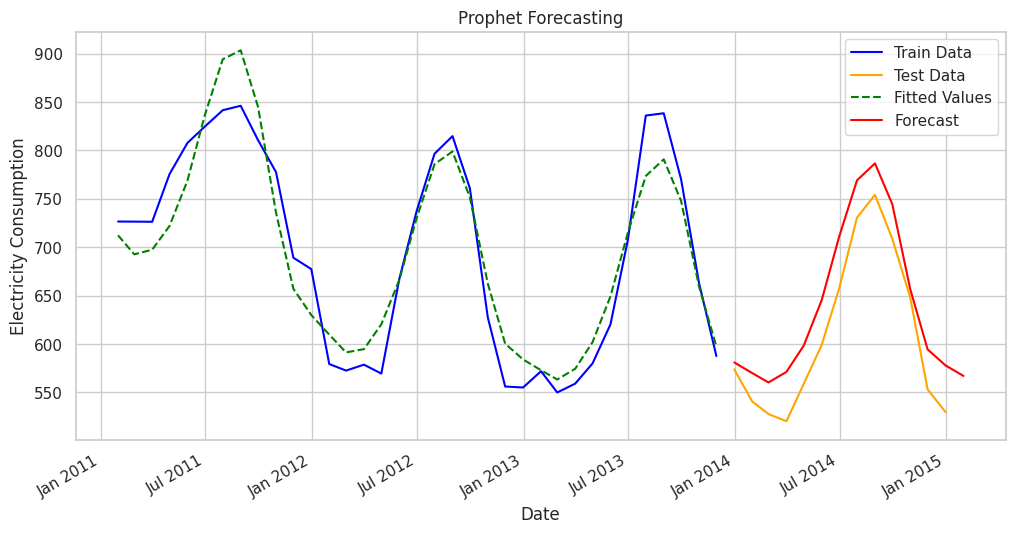

In [ ]:
final_periods = ((test_data['ds'].max().to_period('M') - train_data['ds'].max().to_period('M')).n + 1)
future = final_model.make_future_dataframe(periods=final_periods, freq='M')
final_forecast = final_model.predict(future)

plt.figure(figsize=(12,6))
plt.plot(train_data['ds'], train_data['y'], label="Train Data", color='blue')
plt.plot(test_data['ds'], test_data['y'], label="Test Data", color='orange')
plt.plot(final_forecast['ds'][:len(train_data)], final_forecast['yhat'][:len(train_data)], label="Fitted Values", linestyle='--', color='green')
plt.plot(final_forecast['ds'][len(train_data):], final_forecast['yhat'][len(train_data):], label="Forecast", color='red')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()
plt.xlabel("Date")
plt.ylabel("Electricity Consumption")
plt.title("Prophet Forecasting")
plt.legend()
plt.grid(True)
plt.show()

# LSTM

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

In [ ]:
# Reshape for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, activation='relu'),
    Dense(y_steps)  # Output layer with y_steps neurons
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=500, validation_data=(X_val, y_val), batch_size=64)

# Evaluate on test data
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(X_test)
print("Predictions:", y_pred)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 416734.4375 - val_loss: 282271.4375
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step - loss: 450579.6250 - val_loss: 312029.0000
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 427059.5312 - val_loss: 293890.2812
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 404876.3125 - val_loss: 308611.6562
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 395011.4375 - val_loss: 286298.0625
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 402306.5625 - val_loss: 256440.3438
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 370078.9062 - val_loss: 250305.6562
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 356628.8125 - val_loss: 227730.4219
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 349680.5312 - val_loss: 192775.2188
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 337353.5625 - val_loss: 220106.6562
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step 

In [ ]:
# Merge training and validation sets for final training
X_train_final = np.concatenate((X_train, X_val), axis=0)
y_train_final = np.concatenate((y_train, y_val), axis=0)

In [ ]:
# Train the model
model.fit(X_train_final, y_train_final, epochs=500, batch_size=64)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 752.1398
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 716.8853
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 737.3696
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 667.9935
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 681.9244
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 642.2131
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 612.1801
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 556.8093
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 524.8324
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 520.6106
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 450.8473
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 454.8921
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 409.7016
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 359.6214
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/ste

In [ ]:
# Evaluate on test data
final_test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
Dev_loss = model.evaluate(X_train_final, y_train_final)
print(f'Dev Loss: {Dev_loss}')

y_pred_test = model.predict(X_test)
y_pred_dev = model.predict(X_train_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3726.5823
Test Loss: 7201.51220703125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3913.0496
Dev Loss: 3913.049560546875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [ ]:
# Compute MAPE manually
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

final_mape_dev = mean_absolute_percentage_error(y_train_final, y_pred_dev)
print(f'Final MAPE (DEV) Loss: {final_mape_dev:.2f}%')

final_mape = mean_absolute_percentage_error(y_test, y_pred_test)
print(f'Final MAPE Loss: {final_mape:.2f}%')

Final MAPE (DEV) Loss: 7.55%
Final MAPE Loss: 7.25%


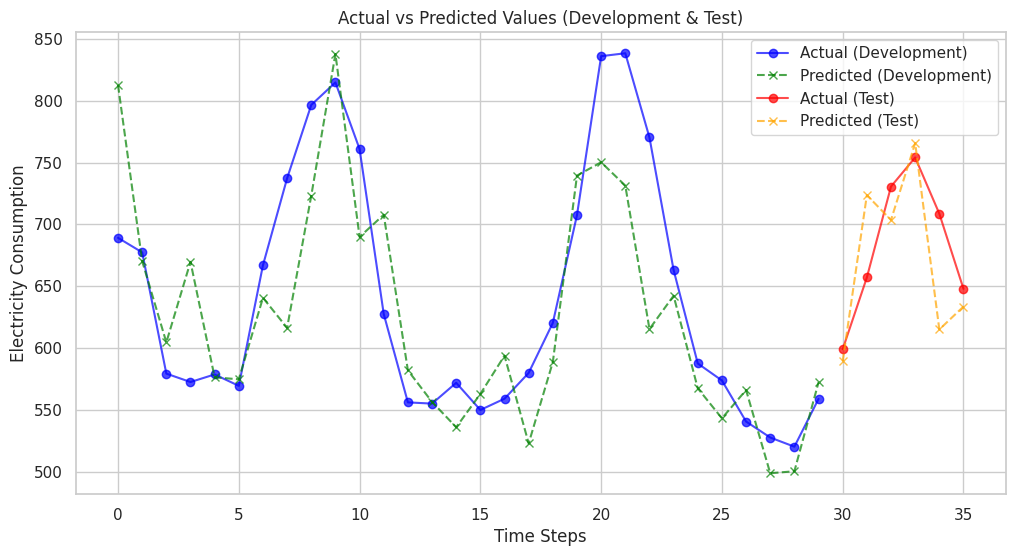

In [ ]:

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Actual vs. Predicted for Development Set
plt.plot(range(len(y_train_final)), y_train_final[:, 0], label='Actual (Development)', marker='o', linestyle='solid', alpha=0.7, color='blue')
plt.plot(range(len(y_train_final)), y_pred_dev[:, 0], label='Predicted (Development)', marker='x', linestyle='dashed', alpha=0.7, color='green')

# Plot Actual vs. Predicted for Test Set
plt.plot(range(len(y_train_final), len(y_train_final) + len(y_test)), y_test[:, 0], label='Actual (Test)', marker='o', linestyle='solid', alpha=0.7, color='red')
plt.plot(range(len(y_train_final), len(y_train_final) + len(y_test)), y_pred_test[:, 0], label='Predicted (Test)', marker='x', linestyle='dashed', alpha=0.7, color='orange')

# Formatting
plt.xlabel('Time Steps')
plt.ylabel('Electricity Consumption')
plt.title('Actual vs Predicted Values (Development & Test)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Function to compute MAPE for each prediction
def compute_mape(y_true, y_pred):
    return np.abs((y_true - y_pred) / y_true) * 100  # Element-wise MAPE calculation

# Assuming y_test and y_pred_test are numpy arrays with shape (n_samples, 2)
# Compute MAPE for each test point for 1st and 2nd predictions
mape_1st_pred = compute_mape(y_test[:, 0], y_pred_test[:, 0])
mape_2nd_pred = compute_mape(y_test[:, 1], y_pred_test[:, 1])
mape_3rd_pred = compute_mape(y_test[:, 2], y_pred_test[:, 2])
mape_4th_pred = compute_mape(y_test[:, 3], y_pred_test[:, 3])
mape_5th_pred = compute_mape(y_test[:, 4], y_pred_test[:, 4])

# Combine MAPE values into a list
mape_data = [mape_1st_pred, mape_2nd_pred, mape_3rd_pred, mape_4th_pred, mape_5th_pred]

# Create boxplot for MAPE of 1st and 2nd predictions
plt.figure(figsize=(8, 6))
sns.boxplot(data=mape_data)
plt.xticks([0, 1, 2, 3, 4], ['1st Prediction', '2nd Prediction', '3rd Prediction', '4th Prediction', '5th Prediction'])
plt.ylabel('MAPE (%)')
plt.title('Boxplot of MAPE for Test Predictions')
plt.grid(True)

# Show plot
plt.show()

NameError: name 'y_test' is not defined